# Jupyter Notebook for Validation of Results

## Overview

This notebook compares the results obtained from the two implementations, `shbundle` and `pyshbundle`, for a specific task.<br>We will focus on evaluating the following:
- Root Mean Squared Error (RMSE)
- Normalized Root Mean Squared Error (NRMSE)
- the difference in time series for a given basin.

## Evaluation Metrics

### 1. Root Mean Squared Error (RMSE)

The RMSE is a measure of the average magnitude of the errors between predicted and observed values.<br> It is calculated as follows:

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({y_i - \bar{y}}\Big)^2}}$$

where:
- $n$ is the number of observations
- ${y_i}$ is the $i_{th}$ observation
- $\bar{y}$ is the mean of observations

### 2. Normalized Root Mean Squared Error (NRMSE)

NRMSE is a normalized version of RMSE, which provides a relative measure of the error compared to the range of the observed values. It is calculated as:

$$ NRMSE = \frac{RMSE}{\max(y) - \min(y)}$$

### 3. Difference in Time Series

We will also visually inspect the difference in time series obtained from both methods to identify any patterns or discrepancies.


## Data Preparation

Before proceeding with the analysis, ensure that the data from both `shbundle` and `pyshbundle` are loaded into the notebook.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# import proplot
import os
import pyshbundle

Initializing PySHbundle v0.0.1


In [3]:
''' Load tws processed data from shbundle as .mat file & from pyshbundle as xarray dataset '''
import scipy.io
# Load the .mat file
data = scipy.io.loadmat('/media/abhishek/DATA/projects/prod_fork/pyshbundle/pyshbundle/validation_data/tws_m.mat')
# Access the variables in the .mat file
var1 = data['tws_m']

temp=xr.open_dataset('/media/abhishek/DATA/projects/prod_fork/pyshbundle/pyshbundle/validation_data/tws_py.nc', engine="netcdf4")
var2=temp.tws.values

### Area Weighting
 grid size is $1^\circ$

In [3]:
# Calculation of area of each corresponding to  the latitudes and longitudes
deg = 1;
x = np.linspace(0, 359+(1-deg), int(360/deg), dtype='double');
y = np.linspace(0, 179+(1-deg), int(180/deg), dtype='double');
x1 = np.linspace(1*deg, 360, int(360/deg), dtype='double');
y1 = np.linspace(1*deg, 180, int(180/deg), dtype='double');
lambd,theta = np.meshgrid(x,y)  
lambd1,theta1 = np.meshgrid(x1,y1)  
a = np.sin(np.deg2rad(90-theta))-np.sin(np.deg2rad(90-theta1))
b = (lambd1 - lambd)*np.pi/180


# Area of each grid (360*720)
area = (6378.137**2)*pow(10,6)*(np.multiply(a,b))        # units m^2

#Multiply with the TWS datasets
# var1_=np.zeros(var1.shape)
# var2_=np.zeros(var2.shape)
# for i in range(0,var1.shape[0],1):
#     var1_[i,:,:] = np.multiply(var1[i,:,:],area)
#     var2_[i,:,:] = np.multiply(var2[i,:,:],area)

In [4]:
''' Write data to netcdf files to clip using geopandas '''
gs=1;
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
tws_py_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var2)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)

tws_m_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var1)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
tws_py_jpl, tws_m_jpl

(<xarray.Dataset>
 Dimensions:  (time: 252, lat: 180, lon: 360)
 Coordinates:
   * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
   * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
   * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
 Data variables:
     tws      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
 Attributes:
     description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...,
 <xarray.Dataset>
 Dimensions:  (time: 252, lat: 180, lon: 360)
 Coordinates:
   * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
   * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
   * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
 Data variables:
     tws      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
 Attributes:
     description:  TWS Anomaly corresponding to long term (2004-2010) mea

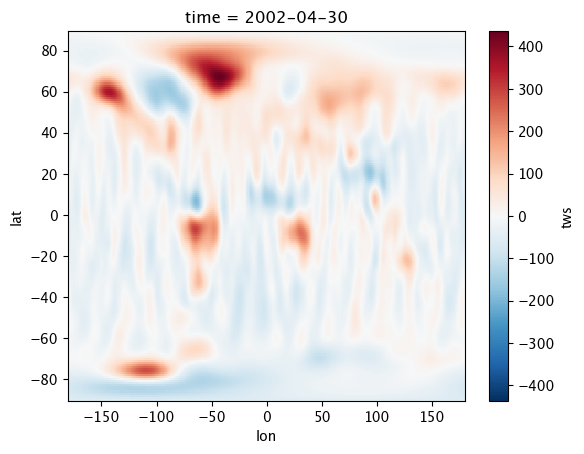

In [5]:
tws_py_jpl.tws.isel(time=3).plot()

### Gridwise RMSE calculation`

#### Creating a mask to remove the months of data which is missing (NaN)

In [6]:
nan_mask = np.all(np.isnan(tws_py_jpl.tws.values), axis=(1, 2))
nan_mask

array([ True,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
        True, False,

In [7]:
var1[~nan_mask].shape   # we see that the size of data has reduced to 196 months

(196, 180, 360)

In [8]:
diff = var1[~nan_mask] - var2[~nan_mask]
squared_diff=diff**2
mean_squared_diff=np.mean(squared_diff, axis=0)
rmse=np.sqrt(mean_squared_diff)
nrmse=rmse/np.std(var1[~nan_mask], axis=0)
std_=np.std(var1[~nan_mask], axis=0)

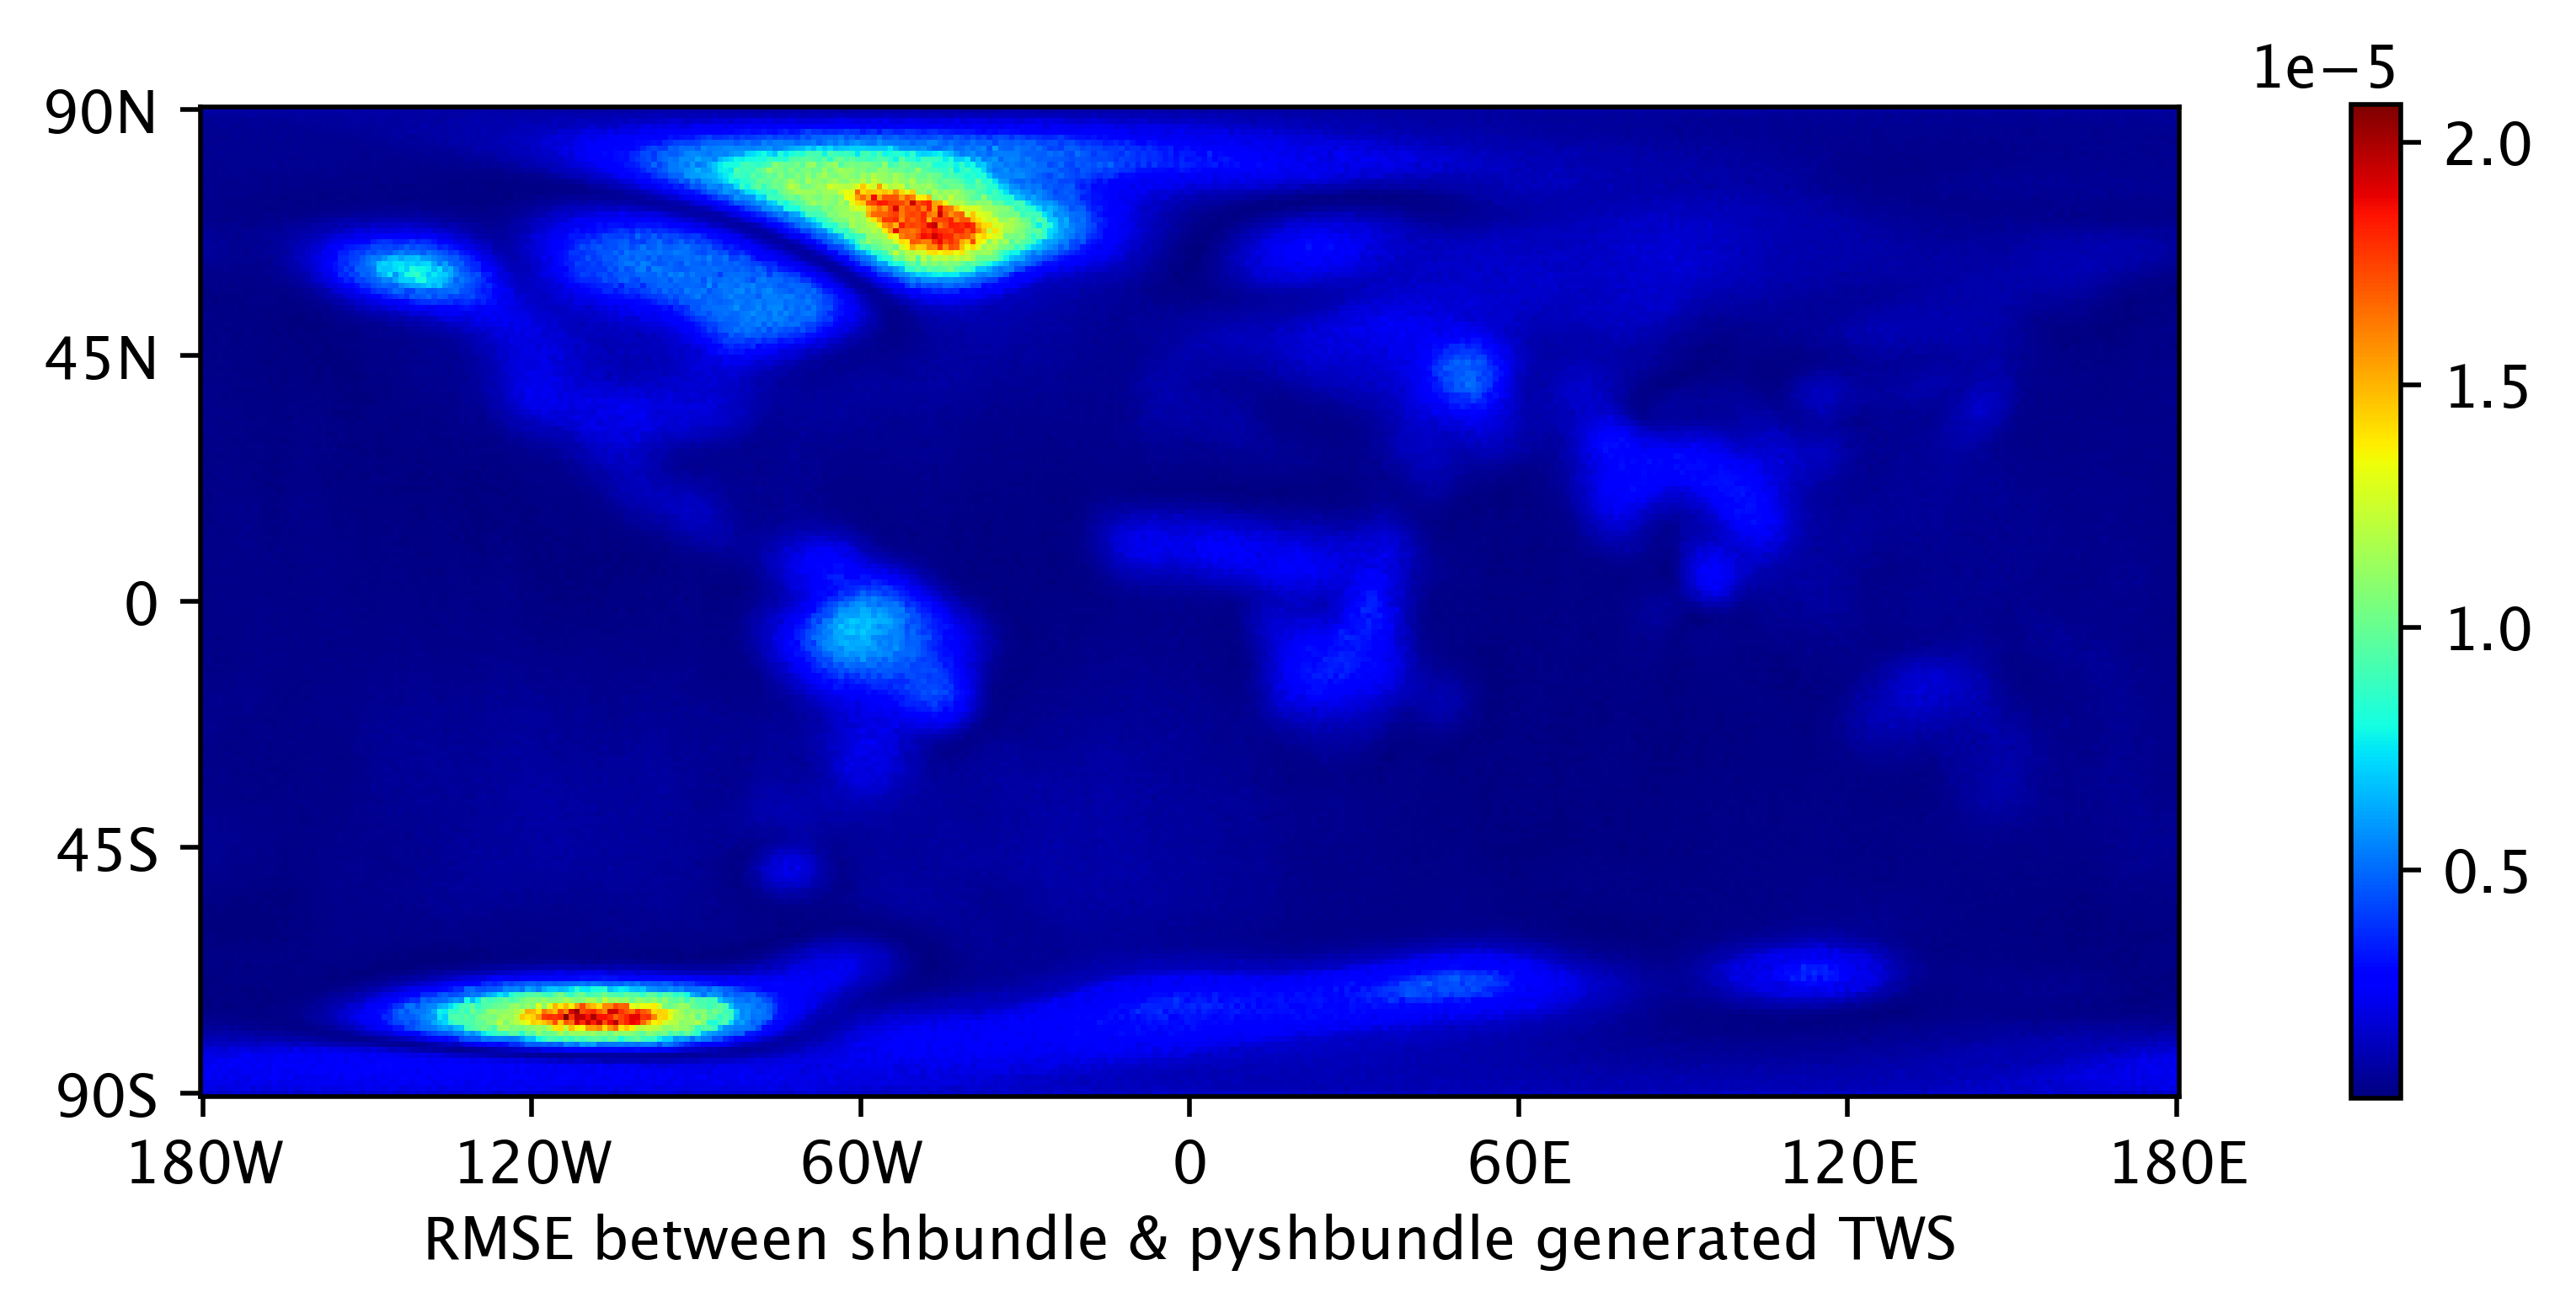

In [9]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=500, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(rmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('RMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


plt.savefig('../pyshbundle/pic/02_error_rmse.png')
plt.show()

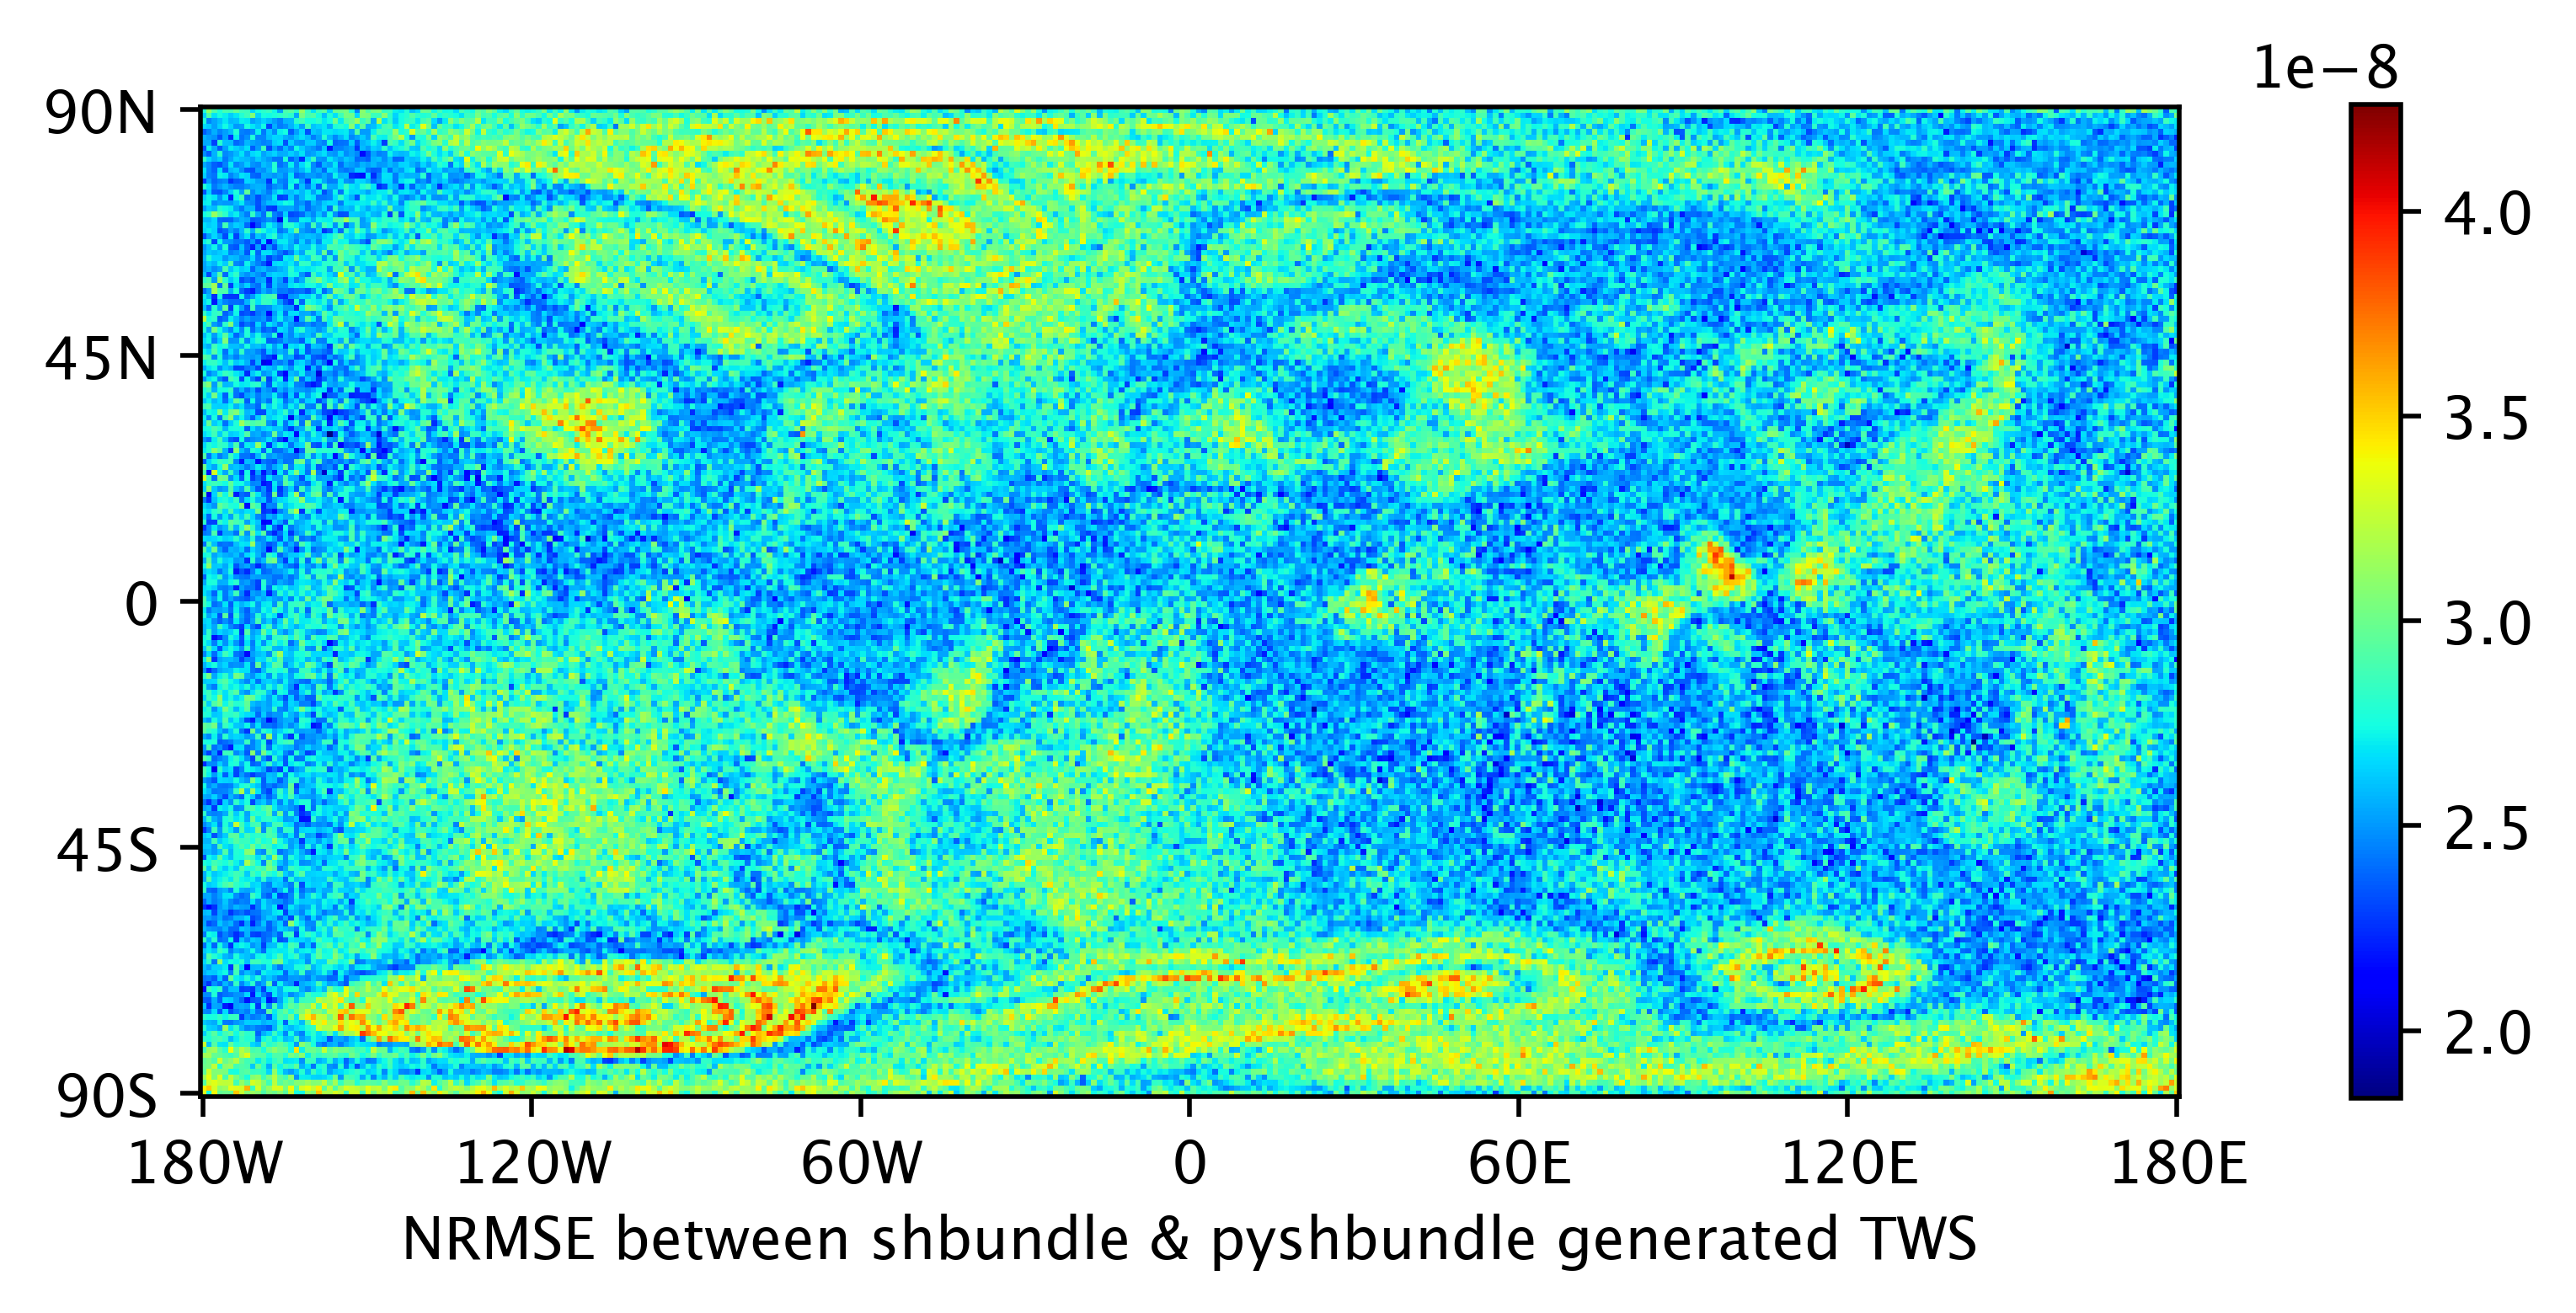

In [10]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=500, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(nrmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('NRMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


plt.savefig('../pyshbundle/pic/02_error_nrmse.png')
plt.show()

### `Basin avg RMSE`

In [11]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

<Axes: >

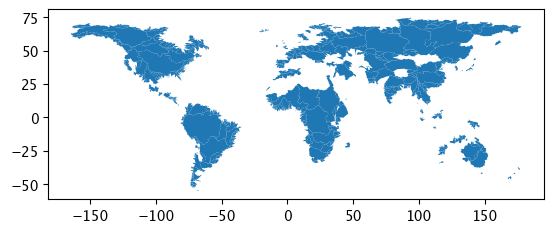

In [12]:
# import shapefile
path='/Users/vivek/Desktop/vivek_downloads/mrb_shp_zip/mrb_basins.shp'
shp = gpd.read_file(path)
shp.plot()

In [13]:
shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MRBID       520 non-null    int64   
 1   RIVER_BASI  520 non-null    object  
 2   CONTINENT   520 non-null    object  
 3   SEA         520 non-null    object  
 4   OCEAN       520 non-null    object  
 5   SUM_SUB_AR  520 non-null    float64 
 6   Shape_Leng  520 non-null    float64 
 7   Shape_Area  520 non-null    float64 
 8   geometry    520 non-null    geometry
dtypes: float64(3), geometry(1), int64(1), object(4)
memory usage: 36.7+ KB


In [14]:
temp=shp['RIVER_BASI']
basin_name=global_name='AMAZON (also AMAZONAS)'   #'AMAZON (also AMAZONAS)'  #'GANGES'

     MRBID              RIVER_BASI      CONTINENT             SEA  \
186   3203  AMAZON (also AMAZONAS)  South America  North Atlantic   

              OCEAN  SUM_SUB_AR  Shape_Leng  Shape_Area  \
186  Atlantic Ocean   5965893.5  167.089927  488.059318   

                                              geometry  
186  POLYGON ((-50.71667 -1.77083, -50.72124 -1.772...  
Basin area is : 4880593178120.001 m²


/var/folders/xn/hqmnb1b15tj56kbl64kd3sv80000gn/T/ipykernel_46780/2441618276.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  basin_area=np.float64(shp_hel['Shape_Area'])*1e6*1e3*1e1 # basin area already in m^2


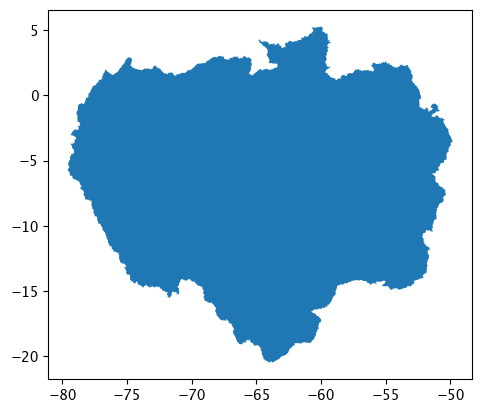

In [15]:
shp_hel=shp[shp['RIVER_BASI']==global_name]
print(shp_hel.head())
shp_hel.plot()
basin_area=np.float64(shp_hel['Shape_Area'])*1e6*1e3*1e1 # basin area already in m^2
print('Basin area is :', basin_area, 'm\u00b2');

In [16]:
tws_py_jpl=tws_py_jpl*area;
tws_m_jpl=tws_m_jpl*area;

In [17]:
# clip data using shapefile
''' add projection system to nc '''
basin_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_py_jpl_ = basin_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
basin_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_m_jpl_ = basin_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
# mask data with shapefile
basin_tws_py_jpl = basin_tws_py_jpl_.rio.clip(shp_hel.geometry.apply(mapping), shp_hel.crs,drop=False)
basin_tws_m_jpl = basin_tws_m_jpl_.rio.clip(shp_hel.geometry.apply(mapping), shp_hel.crs,drop=False)

basin_avg_tws_py_jpl=basin_tws_py_jpl.tws.sum(dim=('lon','lat'), skipna=True)/basin_area
basin_avg_tws_m_jpl=basin_tws_m_jpl.tws.sum(dim=('lon','lat'), skipna=True)/basin_area

In [18]:
# diff of shbundle and pyshbundle
diff_basin_avg_tws=basin_avg_tws_m_jpl.data-basin_avg_tws_py_jpl.data

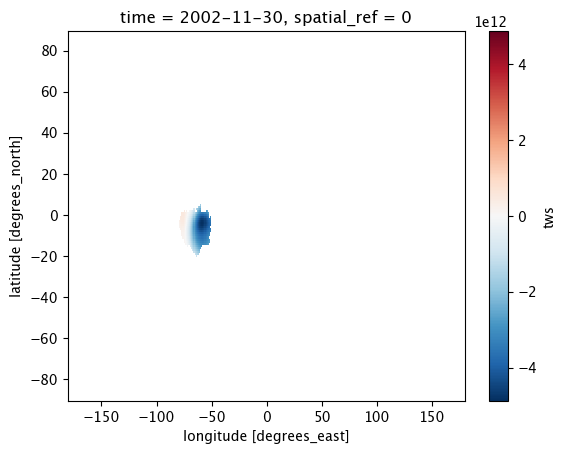

In [19]:
basin_tws_py_jpl.tws.isel(time=10,).plot()

In [20]:
diff_basin_avg_tws

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.35278577e-07,
        1.96242240e-08,  0.00000000e+00,  0.00000000e+00, -7.97447584e-08,
       -2.70168982e-07, -8.89875196e-09, -5.15821057e-08,  1.34549651e-07,
       -7.65824666e-08, -1.84797262e-07, -1.54374945e-07,  5.10139586e-07,
        6.89927901e-08,  0.00000000e+00, -1.18724657e-08,  5.40057030e-08,
       -9.19716854e-08, -4.25039616e-07,  3.10748220e-07,  1.10266654e-07,
       -1.63348943e-07,  4.23612832e-07,  4.78802349e-07,  7.30341014e-08,
        7.92442734e-08, -5.75248293e-09,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.20421310e-07, -3.19752758e-07,
        1.20183856e-07,  1.78126780e-08, -2.92770849e-07, -3.34179447e-07,
        4.09151880e-07, -1.80116189e-07,  8.70834072e-09,  1.88544590e-07,
       -4.44745098e-07,  6.27404688e-08, -1.85921152e-07,  2.08820694e-07,
       -1.31603937e-08, -6.62911503e-08, -2.73938895e-07, -7.71571251e-08,
        5.12816172e-07,  

In [21]:
basin_avg_tws_py_jpl = basin_avg_tws_py_jpl.where(~nan_mask, np.nan)
basin_avg_tws_m_jpl = basin_avg_tws_m_jpl.where(~nan_mask, np.nan)


In [22]:
diff_basin_avg_tws[nan_mask]=np.nan
diff_basin_avg_tws

array([            nan,             nan,             nan,  2.35278577e-07,
        1.96242240e-08,             nan,             nan, -7.97447584e-08,
       -2.70168982e-07, -8.89875196e-09, -5.15821057e-08,  1.34549651e-07,
       -7.65824666e-08, -1.84797262e-07, -1.54374945e-07,  5.10139586e-07,
        6.89927901e-08,             nan, -1.18724657e-08,  5.40057030e-08,
       -9.19716854e-08, -4.25039616e-07,  3.10748220e-07,  1.10266654e-07,
       -1.63348943e-07,  4.23612832e-07,  4.78802349e-07,  7.30341014e-08,
        7.92442734e-08, -5.75248293e-09,             nan,             nan,
                   nan,             nan,  5.20421310e-07, -3.19752758e-07,
        1.20183856e-07,  1.78126780e-08, -2.92770849e-07, -3.34179447e-07,
        4.09151880e-07, -1.80116189e-07,  8.70834072e-09,  1.88544590e-07,
       -4.44745098e-07,  6.27404688e-08, -1.85921152e-07,  2.08820694e-07,
       -1.31603937e-08, -6.62911503e-08, -2.73938895e-07, -7.71571251e-08,
        5.12816172e-07,  

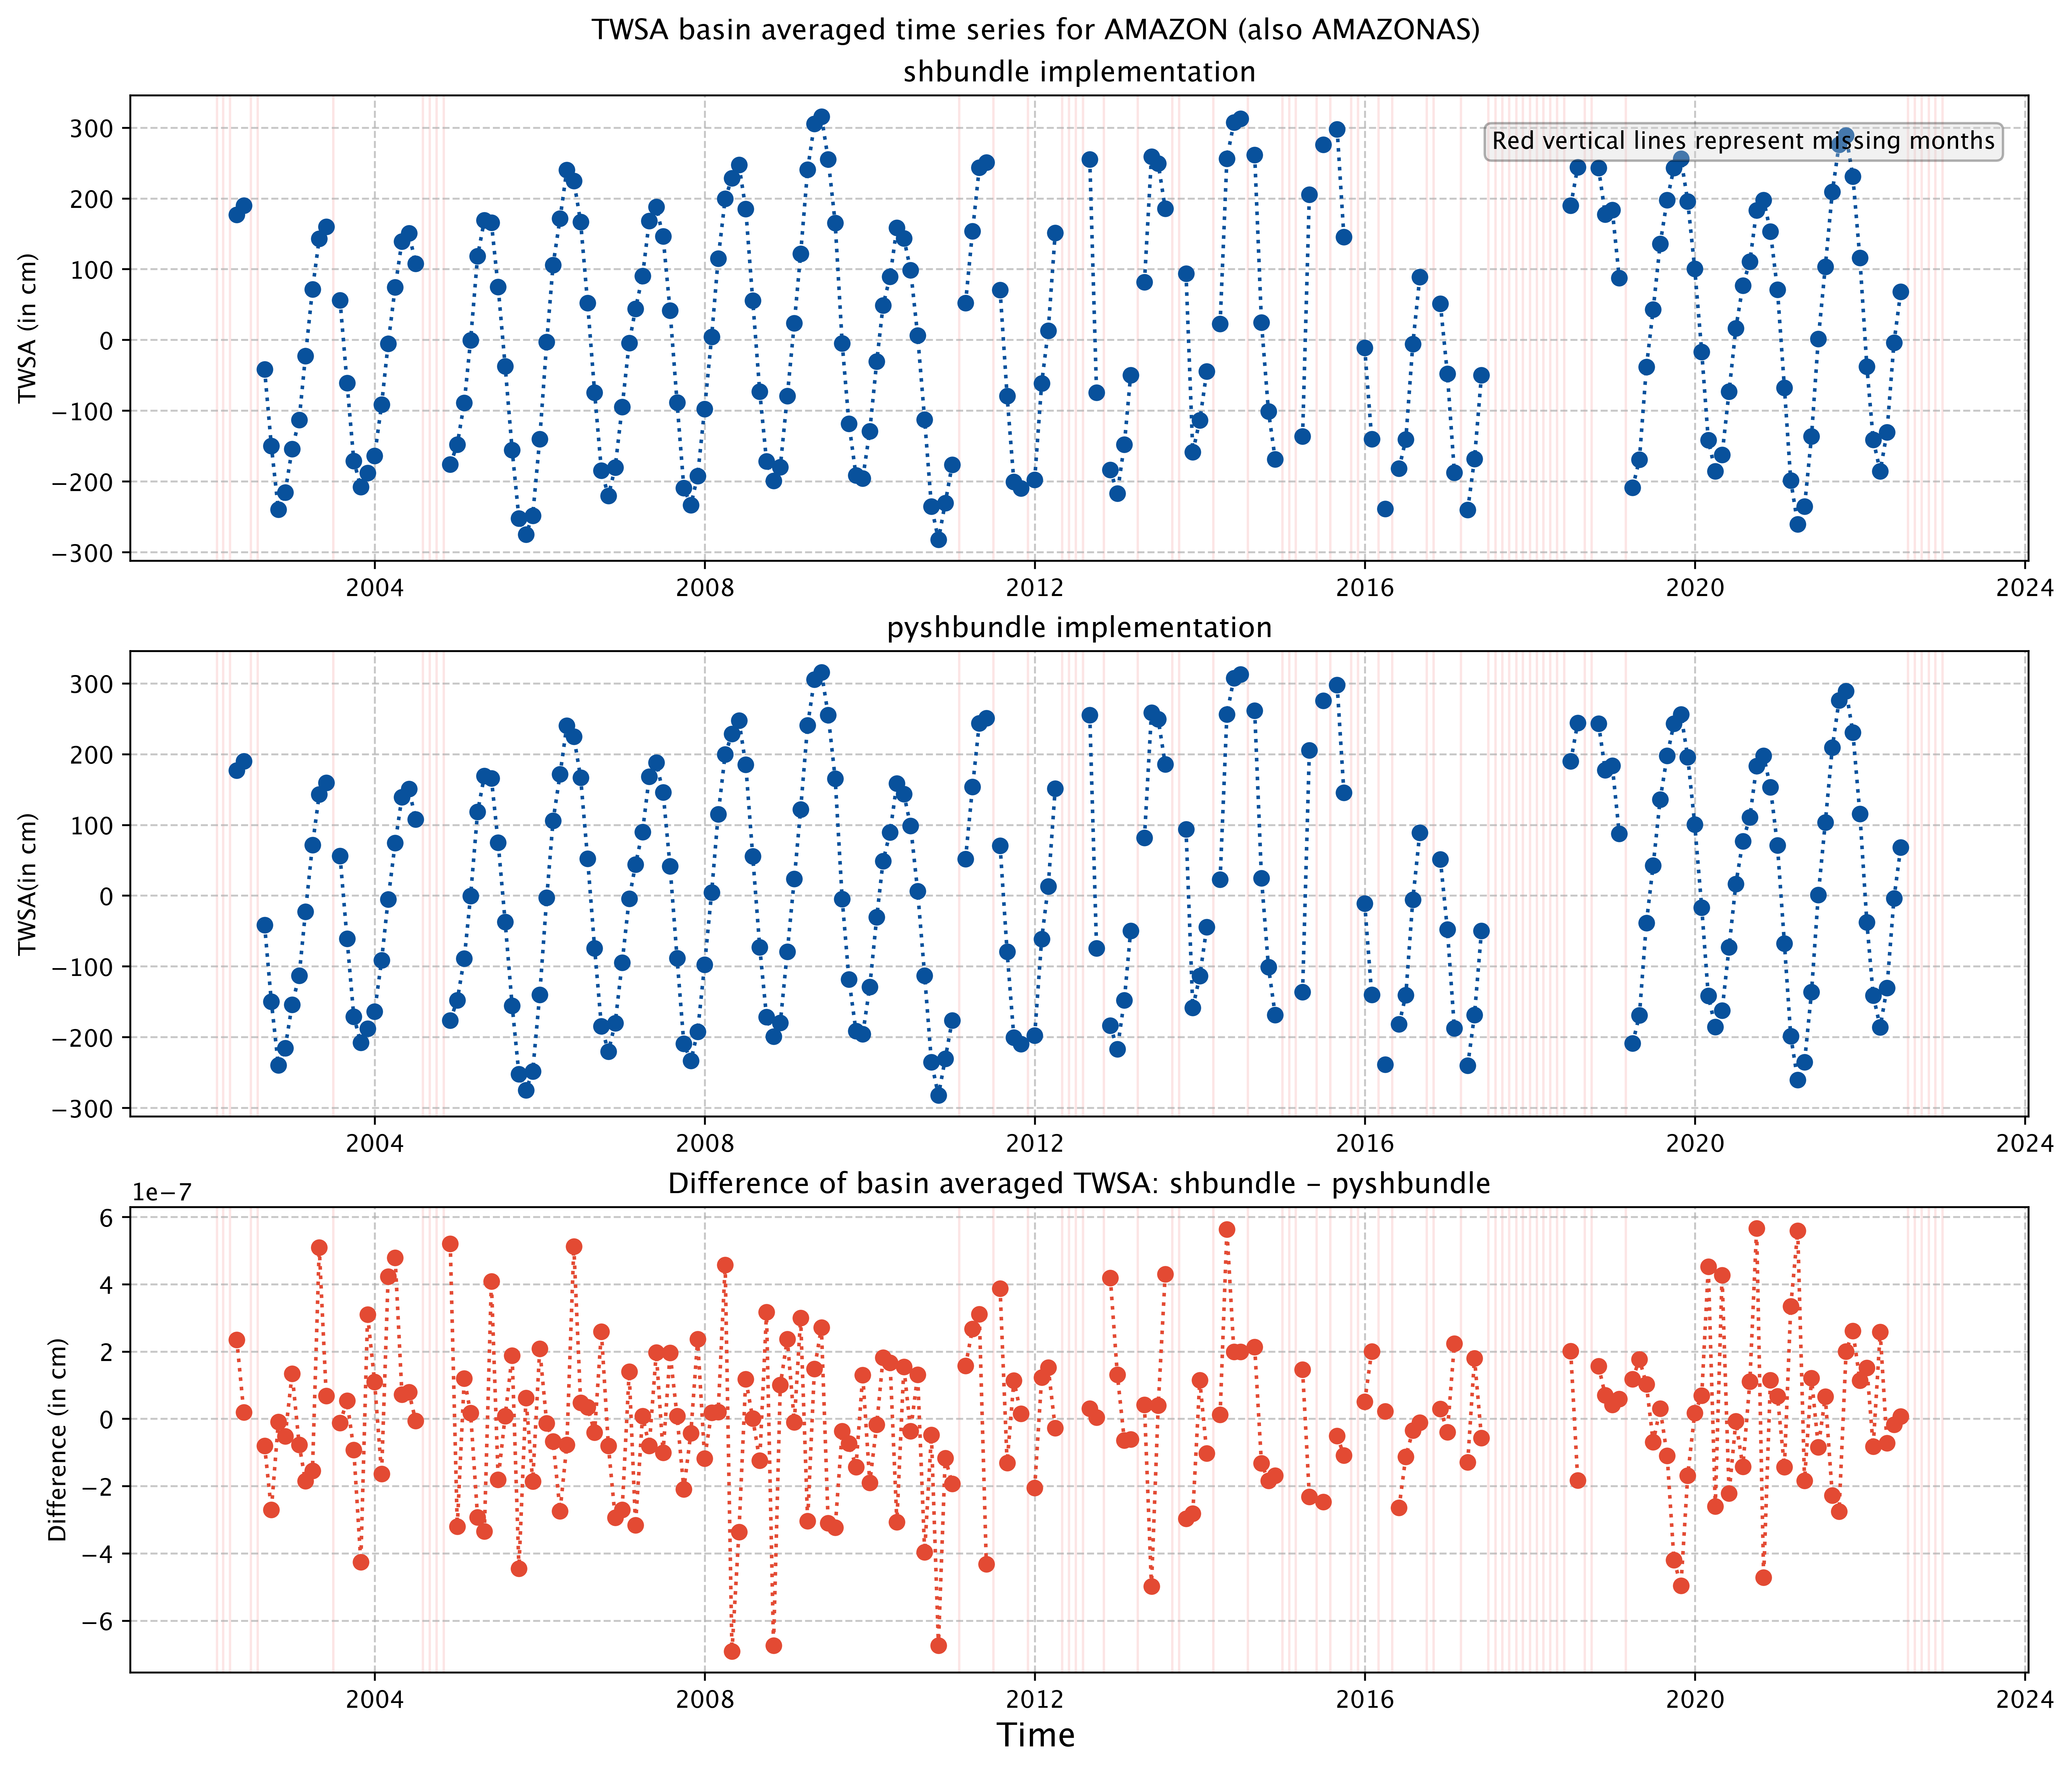

In [23]:
# Create lists for each data
data_list = [basin_avg_tws_m_jpl, basin_avg_tws_py_jpl,diff_basin_avg_tws]  
label_list = ['shbundle implementation', 'pyshbundle implementation','Difference of basin averaged TWSA: shbundle - pyshbundle']
# legend_list = ['Monthly TWSA', 'Monthly TWSA', 'Difference in monthky']
color_list = ['#08519c', '#08519c', '#e34a33']
ylabel_list = ['TWSA (in cm)', 'TWSA(in cm)', 'Difference (in cm)']

# Create subplots with three rows and one column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), constrained_layout=True, dpi=500)

# Iterate over each subplot
for i, ax in enumerate(axes):
    # Plot with a dotted line and markers
    ax.plot(data_list[0].time, data_list[i], label=label_list[i], linestyle='dotted', marker='o', color=color_list[i])

    # Create vertical shaded regions for missing values
    nan_variables = data_list[0].time.values[nan_mask]
    for xc in nan_variables:
        ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

    # Add labels and title

    ax.set_ylabel(ylabel_list[i])
    ax.set_title(f'{label_list[i]}')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    # ax.legend(fancybox=True, edgecolor='black', loc="upper left")
    # Add text box only in the first subplot
    if i == 0:
        ax.text(
            0.85, 0.9,  # Position of the text box (relative to the subplot)
            'Red vertical lines represent missing months',  # Text content
            transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
            ha='center', va='center',  # Center the text
            bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
        )
# Show the plot
# Add a common x-axis label for all subplots
fig.text(0.5, -0.01, 'Time', ha='center', va='center', fontsize=14)
fig.suptitle(f'TWSA basin averaged time series for {basin_name}')
plt.show()
fig.savefig(f'../pyshbundle/pic/03_basin_avg_tws_{basin_name}.png')

#### Global area weighted water budget closure

In [24]:
# Area of grids
global_grid_area = np.sum(area)
print(f'global surface area:', {global_grid_area})

global surface area: {511207893395810.94}


In [25]:
# clip data using shapefile
''' add projection system to nc '''
global_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)
global_tws_py_jpl_ = global_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
global_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)
global_tws_m_jpl_ = global_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
global_avg_tws_py_jpl=global_tws_py_jpl_.tws.sum(dim=('lon','lat'), skipna=True)/global_grid_area
global_avg_tws_m_jpl=global_tws_m_jpl_.tws.sum(dim=('lon','lat'), skipna=True)/global_grid_area

In [26]:
global_avg_tws_py_jpl=global_avg_tws_py_jpl.where(~nan_mask, np.nan)
global_avg_tws_m_jpl=global_avg_tws_m_jpl.where(~nan_mask, np.nan)

In [27]:
diff_global=global_avg_tws_m_jpl-global_avg_tws_py_jpl
diff_global=diff_global.where(~nan_mask, np.nan)
diff_global

<xarray.DataArray 'tws' (time: 252)>
array([            nan,             nan,             nan,  5.87495581e-09,
       -4.26220188e-09,             nan,             nan, -1.39690916e-08,
       -7.80650405e-09, -6.42466955e-09, -8.19053601e-09,  6.63722180e-09,
        9.31248611e-09, -5.73922217e-09,  1.89797284e-09,  8.24558750e-09,
        3.79564979e-09,             nan,  1.93736283e-09, -1.83970935e-09,
        3.81903080e-09, -2.62595352e-09, -2.38501967e-09, -1.87194473e-10,
       -1.11290594e-09,  9.30282171e-10,  2.59435122e-09,  2.16734215e-10,
        2.78564435e-09, -7.79716633e-09,             nan,             nan,
                   nan,             nan,  1.23424979e-09, -6.35301907e-09,
        1.16987436e-10,  1.88050607e-09, -4.28003858e-09, -2.50724423e-09,
        9.53246787e-09,  6.83307466e-09,  2.47473155e-09,  8.28585819e-10,
       -1.35002966e-09, -1.28249041e-09, -5.63240343e-09,  2.24804596e-09,
       -3.87201222e-10, -6.36321548e-09, -6.67632138e-09,  1.87592908e-09,
        2.03898028e-09,  2.05827622e-09,  1.07546493e-11, -1.64323459e-09,
        2.35863086e-09,  3.71168101e-10, -2.67426968e-09, -6.57373012e-09,
        5.83936549e-10, -2.58795081e-09, -1.10073103e-09,  3.78735420e-09,
        1.29334412e-09, -3.38108066e-09,  7.70707313e-11,  3.39191203e-11,
       -9.98676164e-09, -6.64016670e-09, -7.93314314e-12, -1.23655149e-09,
       -1.55859958e-09, -2.62608878e-09,  5.01677708e-09, -3.52715957e-09,
       -6.91498263e-09, -1.66997015e-09,  1.49252949e-10,  4.41058182e-09,
...
       -2.25715009e-09,  3.90585377e-09, -7.19809835e-10,  9.95092245e-09,
                   nan,             nan,  1.84929549e-09,  4.66816740e-09,
        1.02632319e-08,             nan, -6.80606903e-09,  1.77905312e-08,
        8.67089442e-09,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  1.34698525e-08,  1.69771660e-10,             nan,
                   nan,  1.24826757e-08, -1.13186687e-08,  6.77686448e-09,
       -2.11018253e-10,             nan,  8.87058393e-09,  6.98567502e-10,
       -1.24433546e-08, -6.44041492e-09,  1.04640937e-09,  6.78977216e-09,
       -1.17973491e-09, -1.28959044e-09,  3.04477010e-10,  4.69978058e-09,
        4.11641754e-09,  1.30738833e-08, -1.37414664e-08,  1.06418579e-08,
        9.08540773e-09,  4.90126882e-09,  6.11482531e-09, -6.40431824e-09,
        1.84916176e-08, -6.10343218e-09,  6.43381159e-09,  1.89344788e-08,
        4.24699294e-09,  3.45377812e-09,  3.00118879e-10, -7.84007524e-10,
        4.93618371e-09, -2.34315210e-09,  4.80704143e-09, -9.03252752e-09,
       -2.54969344e-09,  6.18850443e-09,  1.40659171e-08, -4.17270724e-09,
        6.13672855e-09,  4.88609738e-09,  1.56515462e-08,  3.92765105e-09,
       -5.24295994e-09,  1.21711503e-08,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * time         (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
    spatial_ref  int64 0

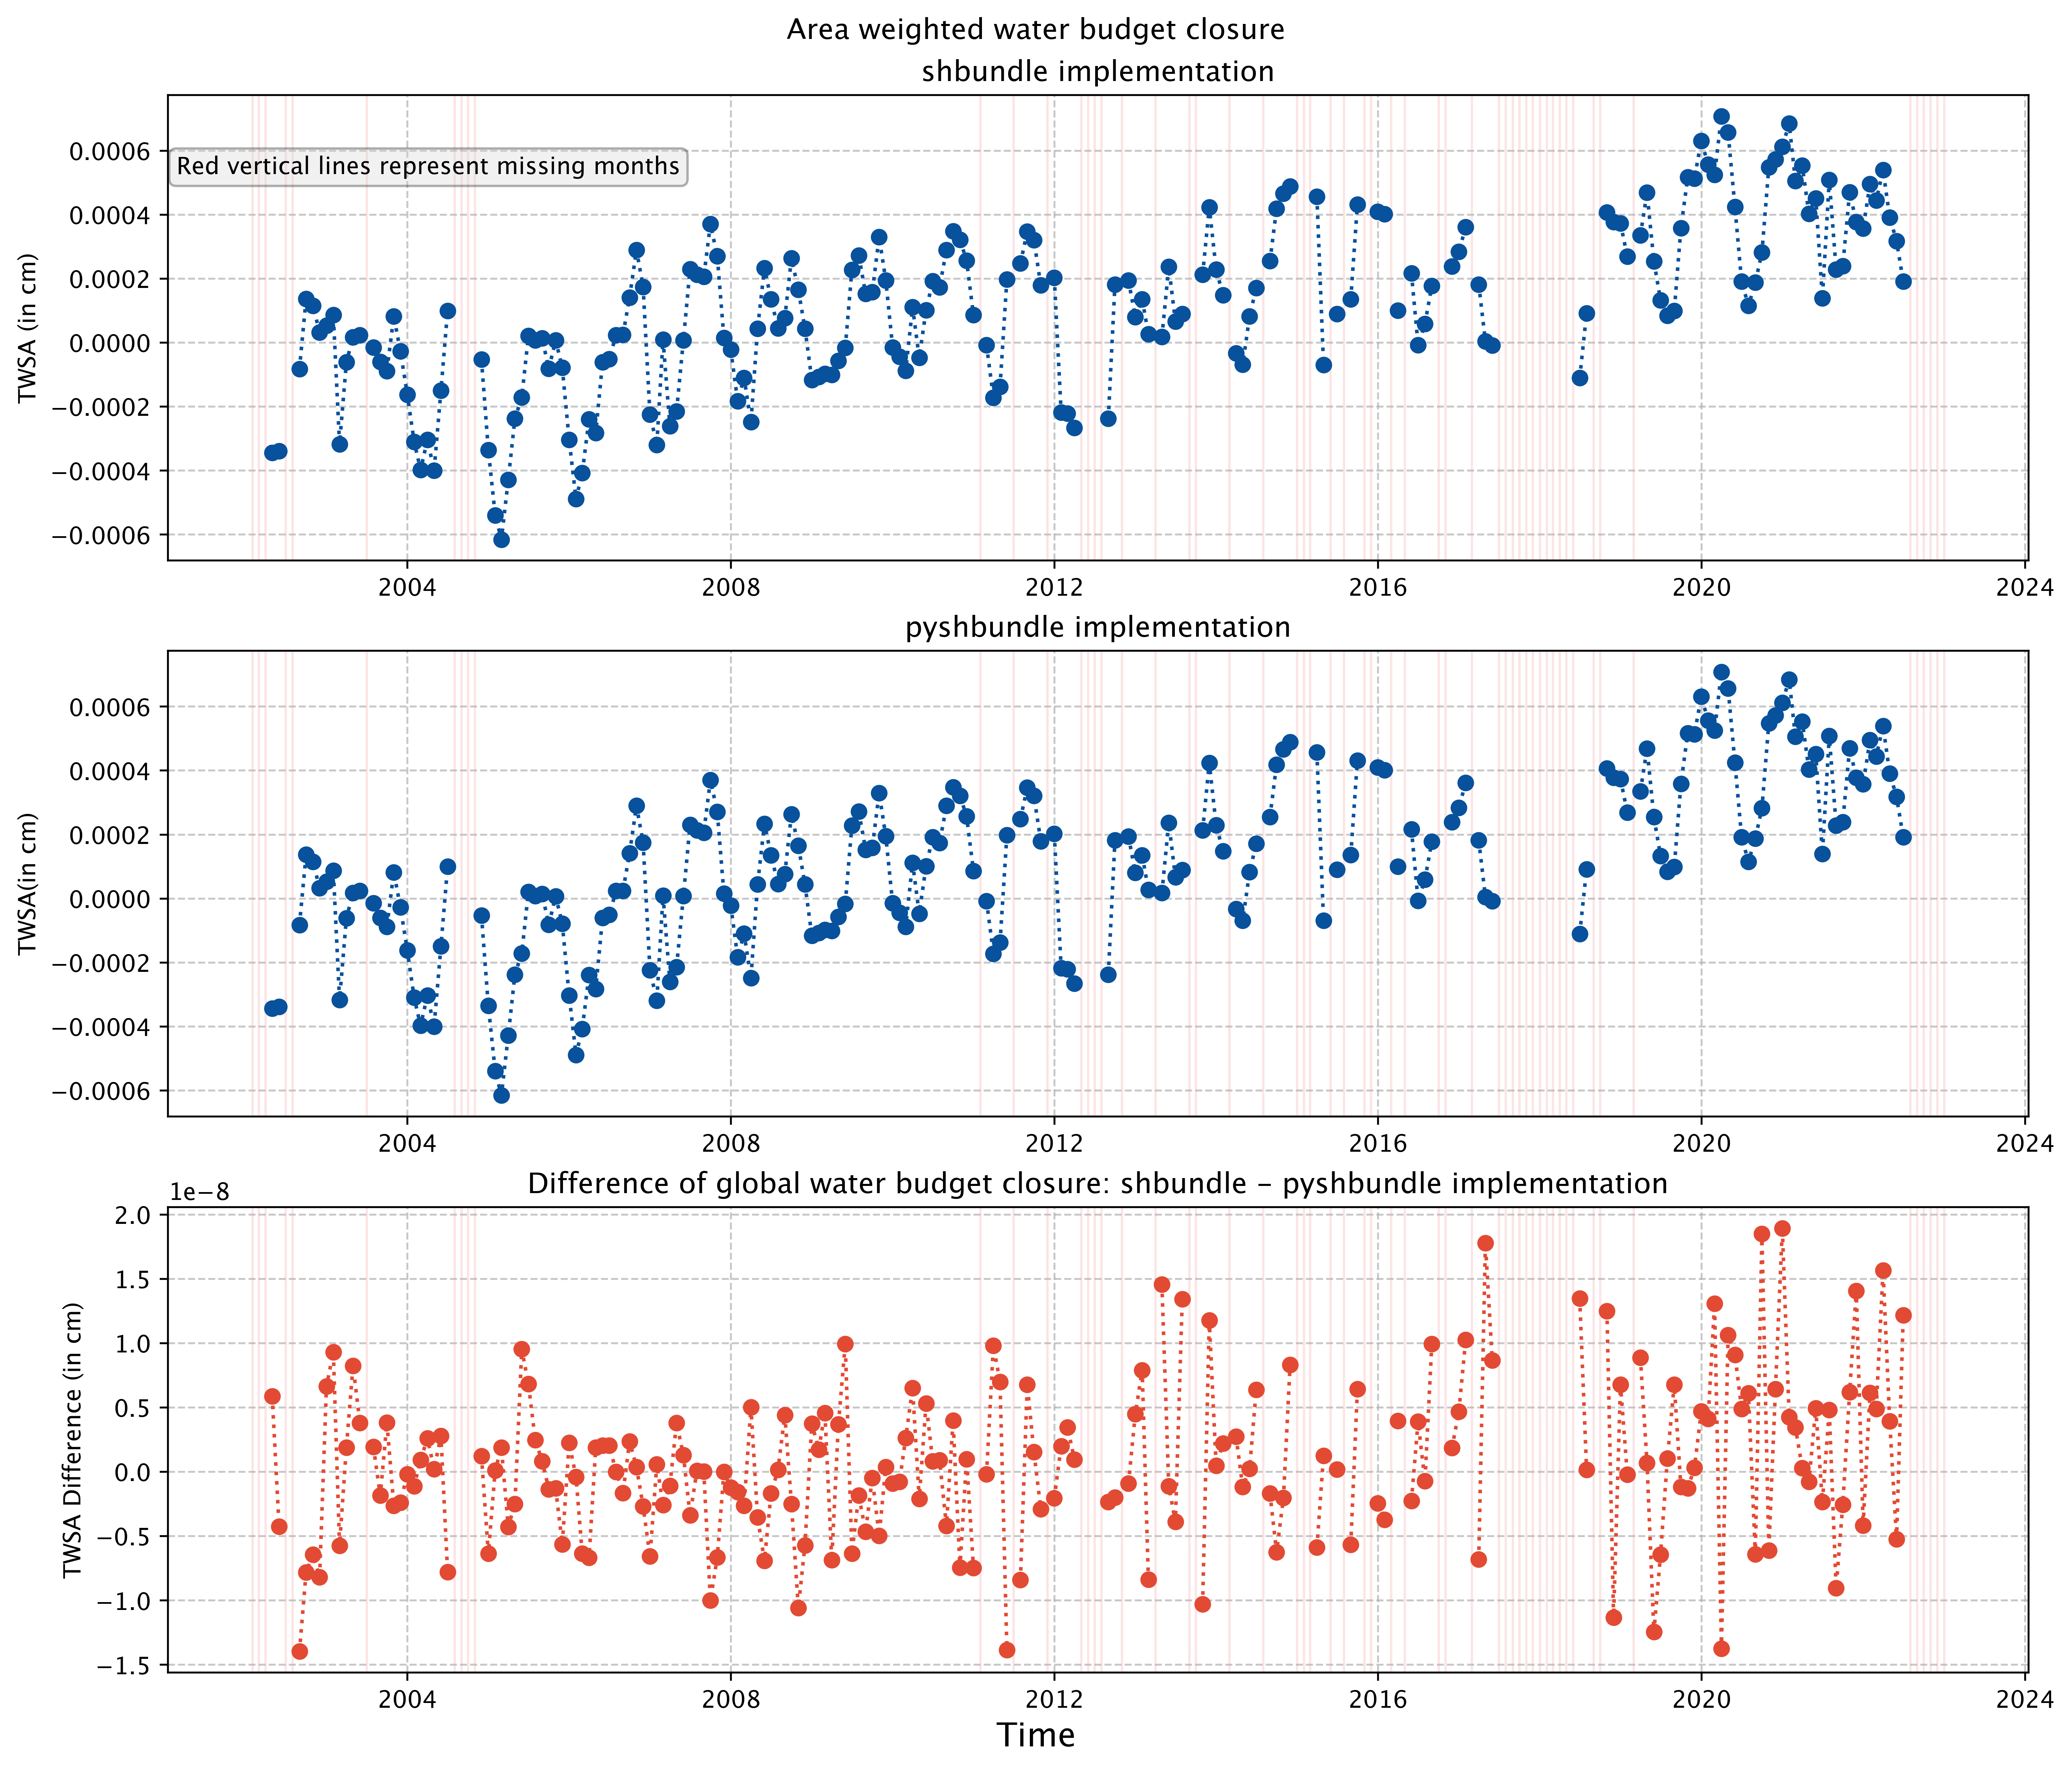

In [28]:
# Create lists for each data
data_list = [global_avg_tws_m_jpl, global_avg_tws_py_jpl,diff_global]  
label_list = ['shbundle', 'pyshbundle','Difference of global water budget closure: shbundle - pyshbundle']  
color_list = ['#08519c', '#08519c', '#e34a33']
ylabel_list = ['TWSA (in cm)', 'TWSA(in cm)', 'TWSA Difference (in cm)']

# Create subplots with three rows and one column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), constrained_layout=True, dpi=500)

# Iterate over each subplot
for i, ax in enumerate(axes):
    # Plot with a dotted line and markers
    ax.plot(data_list[0].time, data_list[i], label=label_list[i], linestyle='dotted', marker='o', color=color_list[i])

    # Create vertical shaded regions for missing values
    nan_variables = data_list[0].time.values[nan_mask]
    for xc in nan_variables:
        ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

    # Add labels and title

    ax.set_ylabel(ylabel_list[i])
    ax.set_title(f'{label_list[i]} implementation')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    # ax.legend(fancybox=True, edgecolor='black', loc="upper left")
    # Add text box only in the first subplot
    if i == 0:
        ax.text(
            0.14, 0.845,  # Position of the text box (relative to the subplot)
            'Red vertical lines represent missing months',  # Text content
            transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
            ha='center', va='center',  # Center the text
            bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
        )
# Show the plot
# Add a common x-axis label for all subplots
fig.text(0.5, -0.01, 'Time', ha='center', va='center', fontsize=14)
fig.suptitle(f'Area weighted water budget closure')
plt.show()
# fig.savefig(f'./global_wb_closure.png')